In [1]:
import os

In [2]:
%pwd

'c:\\Users\\Sanju\\WORKSPACE\\End-to-End-MLOPS-AWS-Deployment-Project\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\Sanju\\WORKSPACE\\End-to-End-MLOPS-AWS-Deployment-Project'

In [5]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_path: Path
    model_name: str
    max_depth: int
    learning_rate: float
    n_estimators: int
    target_column: str

In [6]:
from MLProject.constants import *
from MLProject.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer
        params = self.params.XgboostRegressor
        schema = self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_trainer_config = ModelTrainerConfig(
            root_dir= config.root_dir,
            train_data_path= config.train_data_path,
            test_data_path= config.test_data_path,
            model_path=config.model_path,
            model_name= config.model_name,
            learning_rate= params.learning_rate,
            max_depth= params.max_depth,
            n_estimators= params.n_estimators,
            target_column= schema.name
        )

        return model_trainer_config

In [8]:
import pandas as pd
import os
from MLProject import logger
from xgboost import XGBRegressor
import pickle
from MLProject.utils.common import save_object
import joblib

In [9]:
class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config

    def train(self):
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)

        train_x = train_data.drop([self.config.target_column], axis=1)
        test_x = test_data.drop([self.config.target_column], axis=1)
        train_y = train_data[[self.config.target_column]]
        test_y = test_data[[self.config.target_column]]


        xgb = XGBRegressor(max_depth = self.config.max_depth, learning_rate = self.config.learning_rate, 
                           n_estimators=self.config.n_estimators, random_state=42)
        
        xgb.fit(train_x, train_y)

        joblib.dump(xgb, os.path.join(self.config.root_dir, self.config.model_name))

        save_object(
            file_path = self.config.model_path,
            obj = xgb
        )

        return self.config.model_path

In [10]:
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer_config = ModelTrainer(config=model_trainer_config)
    model_trainer_config.train()
except Exception as e:
    raise e

[2024-02-25 23:00:53,397: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-02-25 23:00:53,399: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-25 23:00:53,402: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-25 23:00:53,403: INFO: common: created directory at: artifacts]
[2024-02-25 23:00:53,403: INFO: common: created directory at: artifacts/model_trainer]


In [2]:
from pathlib import Path
import pickle

In [3]:
with open(Path(r'C:\Users\Sanju\WORKSPACE\End-to-End-MLOPS-AWS-Deployment-Project\artifacts\models\preprocessor.pkl'), 'rb') as file:
    preprocessor = pickle.load(file)

In [4]:
with open(Path(r'C:\Users\Sanju\WORKSPACE\End-to-End-MLOPS-AWS-Deployment-Project\artifacts\models\model.pkl'), 'rb') as file1:
    model = pickle.load(file1)

In [8]:
import pandas as pd
import numpy as np

In [9]:
f = preprocessor.transform(pd.DataFrame([['Zambia', 'Truck', 'Tablet', 47227, 5.78, 0.19, 4959.0, 9973.51, 535.03, 'Delivered Early', 'India']], columns=['Drop_point', 'Shipment_Mode', 'Dosage_Form', 'Line_Item_Quantity', 'Pack_Price',
                             'Unit_Price', 'Weight', 'Freight_Cost', 'Line_Item_Insurance', 'Delivery_Status',
                             'Pickup_Point']))

In [12]:
np.exp(model.predict(f))

array([6564872.5], dtype=float32)

In [24]:
f = pd.read_csv(r'C:\Users\Sanju\WORKSPACE\End-to-End-MLOPS-AWS-Deployment-Project\artifacts\data_validation\test.csv')

In [14]:
f.drop(columns=['Line_Item_Value'], inplace=True)

In [16]:
X_t= preprocessor.transform(f)

In [20]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.9 kB 5.1 MB/s eta 0:00:01
   ------------------------------------- -- 276.5/294.9 kB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00


<Axes: ylabel='Density'>

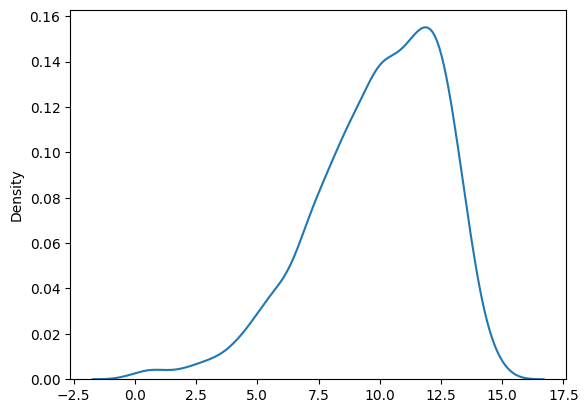

In [22]:
import seaborn as sns
sns.kdeplot(model.predict(X_t))

<Axes: xlabel='Line_Item_Value', ylabel='Density'>

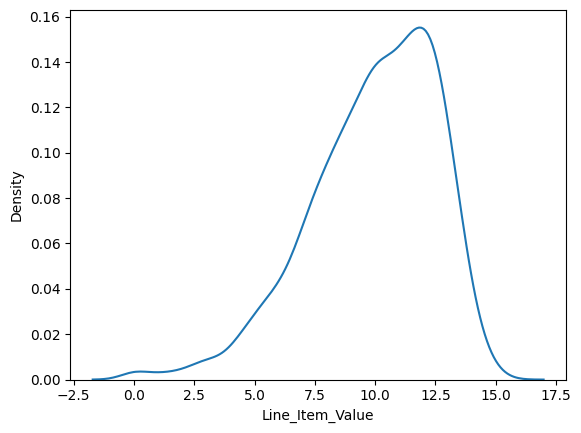

In [25]:
sns.kdeplot(f['Line_Item_Value'])